In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
pd.set_option('display.max_columns', 100)
import sys
sys.path.append('../')
from analib.table import LightGBM

SyntaxError: invalid syntax (3164808180.py, line 11)

In [16]:
df_train = pd.read_csv('/dataset/signate_beginner36/train.csv')
df_test = pd.read_csv('/dataset/signate_beginner36/test.csv')

In [18]:
def preprocess(df):
    df_X = df.drop(columns='Attrition', errors='ignore')

    # 使わないデータの削除
    unique_drop_list = ['id']
    constant_drop_list = ['Over18', 'StandardHours']
    df_X = df_X.drop(columns=unique_drop_list)
    df_X = df_X.drop(columns=constant_drop_list)

    category_list = [
        'BusinessTravel',
        'Department',
        'EducationField',
        'Gender',
        'JobRole',
        'MaritalStatus',
        'OverTime'
    ]
    category_dict = dict()
    for cate in category_list:
        categories = df_X[cate].unique().tolist()
        df_X[cate] = pd.Categorical(df_X[cate], categories=categories)
        category_dict[cate] = categories
    df_X_categories = pd.get_dummies(df_X[category_list], drop_first=True)

    df_X_others = df_X.select_dtypes(exclude='category')

    features = [
        'DistanceFromHome',
        'EmployeeNumber',
        'HourlyRate',
        'PercentSalaryHike',
        'Age',
        'DailyRate',
        'MonthlyIncome',
        'YearsWithCurrManager',
        'JobLevel',
        'NumCompaniesWorked',
        'YearsAtCompany',
        'OverTime_Yes'
    ]
    df_X = pd.concat([df_X_others, df_X_categories], axis=1)[features]

    return df_X

In [19]:
X = preprocess(df_train)
y = df_train[['Attrition']].copy()

# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)
# 学習データを学習用と検証用に分割
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=y_train)

In [20]:
# LightGBMの学習を実行
lgbm_params = {
    'random_state': 42,
    'task': 'train',                # レーニング ⇔　予測predict
    'boosting_type': 'gbdt',        # 勾配ブースティング
    'objective': 'binary',          # 目的関数：多値分類binaly、マルチクラス分類mulit_class
    'metric': 'binary_logloss',     # 検証用データセットで、分類モデルの性能を測る指標
    # 'num_class': 4,               # 目的変数のクラス数
    'learning_rate': 0.01,           # 学習率（初期値0.1）
    'n_estimators': 1000,           # 木の数　default 100
    'num_leaves': 31,               # 決定木の複雑度を調整（初期値31）
    'max_depth': -1,                # default -1
    # 'min_data_in_leaf': 1,          # データの最小数（初期値20）
    'verbosity': -1
}
lgbm = LightGBM(X_train, y_train,
                X_valid, y_valid,
                X_test, y_test)
model, y_prob = lgbm.train(params=lgbm_params)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	train's binary_logloss: 0.464252	valid's binary_logloss: 0.465437
Training until validation scores don't improve for 100 rounds
[2]	train's binary_logloss: 0.461578	valid's binary_logloss: 0.463747
[3]	train's binary_logloss: 0.459051	valid's binary_logloss: 0.462593
[4]	train's binary_logloss: 0.456512	valid's binary_logloss: 0.460969
[5]	train's binary_logloss: 0.454124	valid's binary_logloss: 0.460324
[6]	train's binary_logloss: 0.451799	valid's binary_logloss: 0.459495
[7]	train's binary_logloss: 0.449433	valid's binary_logloss: 0.458092
[8]	train's binary_logloss: 0.447057	valid's binary_logloss: 0.45719
[9]	train's binary_logloss: 0.444737	valid's binary_logloss: 0.456489
[10]	train's binary_logloss: 0.442451	valid's binary_logloss: 0.455427
[11]	train's binary_logloss: 0.440415	valid's binary_logloss: 0.454219
[12]	train's binary_logloss: 0.438421	valid's binary_logloss: 0.453114
[13]	train's binary_logloss: 0.436248	valid's binary_logloss: 0.452323
[14]	train's binary_loglo

In [21]:
y_pred = (y_prob > 0.5).astype(int)

In [22]:
metrics.accuracy_score(y_test, y_pred)
metrics.precision_score(y_true=y_test, y_pred=y_pred)
metrics.recall_score(y_true=y_test, y_pred=y_pred)
metrics.f1_score(y_true=y_test, y_pred=y_pred)
print(metrics.classification_report(
    y_test,
    y_pred,
    target_names=['class_0', 'class_1']))

              precision    recall  f1-score   support

     class_0       0.86      0.99      0.92       197
     class_1       0.85      0.26      0.39        43

    accuracy                           0.86       240
   macro avg       0.85      0.62      0.66       240
weighted avg       0.86      0.86      0.83       240



In [23]:
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
TN = str(cm[0, 0]) + '(TN)'
FP = str(cm[0, 1]) + '(FP)'
FN = str(cm[1, 0]) + '(FN)'
TP = str(cm[1, 0]) + '(TP)'

pd.DataFrame(
    data=np.array([[TN, FP],
                   [FN, TP]]),
    index=['actual_Negative', 'acutal_Positive'],
    columns=['predict_Negative', 'predict_Positive']
)

,predict_Negative,predict_Positive
actual_Negative,195(TN),2(FP)
acutal_Positive,32(FN),32(TP)


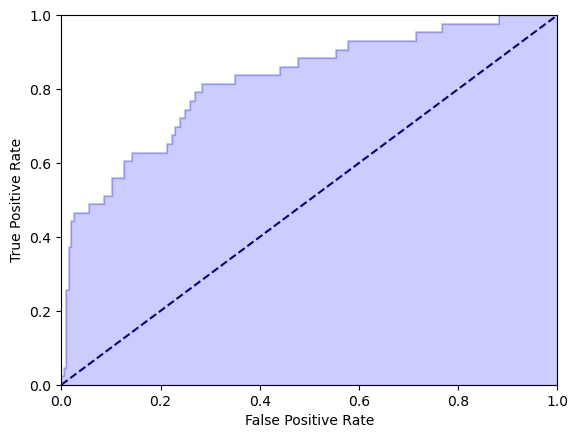

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.show()

0.56981319419666


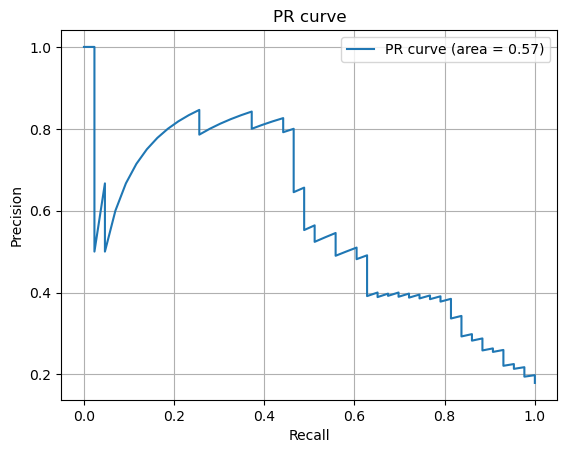

In [25]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, model.predict(X_test))

auc = metrics.auc(recall, precision)
print(auc)

plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
plt.legend()
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [26]:
X_submit = preprocess(df_test)

In [27]:
y_prob_submit = model.predict(X_submit, num_iteration=model.best_iteration)
y_pred_submit = (y_prob_submit > 0.5).astype(int)
y_pred_submit

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [28]:
pd.concat(
    [df_test.iloc[:, 0], pd.DataFrame(y_pred_submit)],
    axis=1
).to_csv(
    f'output/{datetime.now().strftime("%Y%m%d%H%M%S")}.csv',
    header=False,
    index=False
)

OSError: Cannot save file into a non-existent directory: 'output'